<a href="https://colab.research.google.com/github/GIS-ZhangZhen/MangroveGreenness/blob/main/Climatic_sensitivities_of_MGFs_and_EBFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install package *rasterio* for reading tif data

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 6.8 MB/s 


Import packages

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.linear_model import LinearRegression
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import IntVector, Formula

base = importr('base')
rstats = importr('stats')
utils = importr('utils')

# 1.Calculating sensitivites to temperature and precipitation

In [2]:
def detrend(arr,t): #Linearly detrending a time-series vector
    t = t.reshape(-1,1)
    model = LinearRegression()
    model.fit(t,arr)
    trend = model.predict(t)
    detrended = arr-trend
    return detrended

def LM(nirv,x1,x2): #Calculating climatic sensitivites (the partial slopes)
  co = len(nirv[~np.isnan(nirv)])
  if co < 20: 
    return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
  time = np.arange(2001,2021)
  df = pd.DataFrame(np.vstack([time,x1,x2,nirv]).T)
  df.columns = ['time','x1','x2','NIRv']
  
  df = df.dropna(axis=1,how='all')
  df = df.dropna(axis=0,how='any')
  df['NIRv'] = df['NIRv']/df['NIRv'].mean()
  if len(df.columns) < 4:
    return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

  df_detrended = df[df.columns[1:]].apply(detrend, axis=0,args=(np.array(df['time']),))
  for col in df_detrended.columns:
    if df_detrended[col].max() == 0:
      return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
  with localconverter(robjects.default_converter + pandas2ri.converter):
    rsummary = robjects.r['summary']
    fit = rstats.lm('NIRv~x1+x2',data=df_detrended)
    summary = rsummary(fit)
  dollar = base.__dict__["$"]
  r2 = dollar(summary,'r.squared')
  pval = 1-rstats.pf(dollar(summary,'fstatistic')[0],dollar(summary,'fstatistic')[1],dollar(summary,'fstatistic')[2])[0]
  return summary.rx2('coefficients')[1],summary.rx2('coefficients')[2],r2[0],summary.rx2('coefficients')[10],summary.rx2('coefficients')[11],pval

def ClimSens(nirv,x1,x2,dim='time'): 
    return xr.apply_ufunc(
        LM, nirv, x1,x2,
        input_core_dims=[[dim],[dim],[dim]],
        output_core_dims=[[] for _ in range(6)],  
        vectorize=True
        )
    
def LoadData(filepath,threshold=-1000):
  if filepath[-4:] == '.tif':
    data = xr.open_rasterio(filepath)
  elif filepath[-3:] == '.nc':
    data = xr.open_dataset(filepath)
  else:
    return
  data = data.where(data>threshold)
  return data


## 1.1 Analysis based on CRU data

In [6]:
Tmean = LoadData('/content/drive/MyDrive/Greenness/Climate/tmp_CRU.nc',-10) #Annual mean temperature
pre = LoadData('/content/drive/MyDrive/Greenness/Climate/pre_CRU.nc',0) # Annual precipitation
dim = 'time'
vi = 'NIRv'
MGF = LoadData('/content/drive/MyDrive/Greenness/VI/{0}_MGF_05deg.nc'.format(vi),0)
EBF = LoadData('/content/drive/MyDrive/Greenness/VI/{0}_EBF_05deg.nc'.format(vi),0)

MGF_mask = LoadData('/content/drive/MyDrive/Greenness/weight/SpatialCounting_MGF_05deg.tif',0)
EBF_mask = LoadData('/content/drive/MyDrive/Greenness/weight/SpatialCounting_EBF_05deg.tif',0)

MAVI_EBF = EBF[vi].mean(dim).where(EBF_mask>=50)
MAVI_MGF = MGF[vi].mean(dim).where(MGF_mask>=50)

Tsens_EBF,Psens_EBF,r2_EBF,p_Tsens_EBF,p_Psens_EBF,p_EBF = ClimSens(EBF.rename({vi:'data'}),Tmean.rename({'tmp':'data'}),pre.rename({'pre':'data'}))
Tsens_MGF,Psens_MGF,r2_MGF,p_Tsens_MGF,p_Psens_MGF,p_MGF = ClimSens(MGF.rename({vi:'data'}),Tmean.rename({'tmp':'data'}),pre.rename({'pre':'data'}))

filename=['T_EBF_2CRU.nc','T_MGF_2CRU.nc','P_EBF_2CRU.nc','P_MGF_2CRU.nc']
for i,data in enumerate([Tsens_EBF,Tsens_MGF,Psens_EBF,Psens_MGF]):
  data.to_netcdf('/content/drive/MyDrive/Greenness/Sensitivity/'+filename[i])

filename=['T_pvalue_EBF_2CRU.nc','T_pvalue_MGF_2CRU.nc','P_pvalue_EBF_2CRU.nc','P_pvalue_MGF_2CRU.nc']
for i,data in enumerate([p_Tsens_EBF,p_Tsens_MGF,p_Psens_EBF,p_Psens_MGF]):
  data.to_netcdf('/content/drive/MyDrive/Greenness/Sensitivity/'+filename[i])

Ploting a example

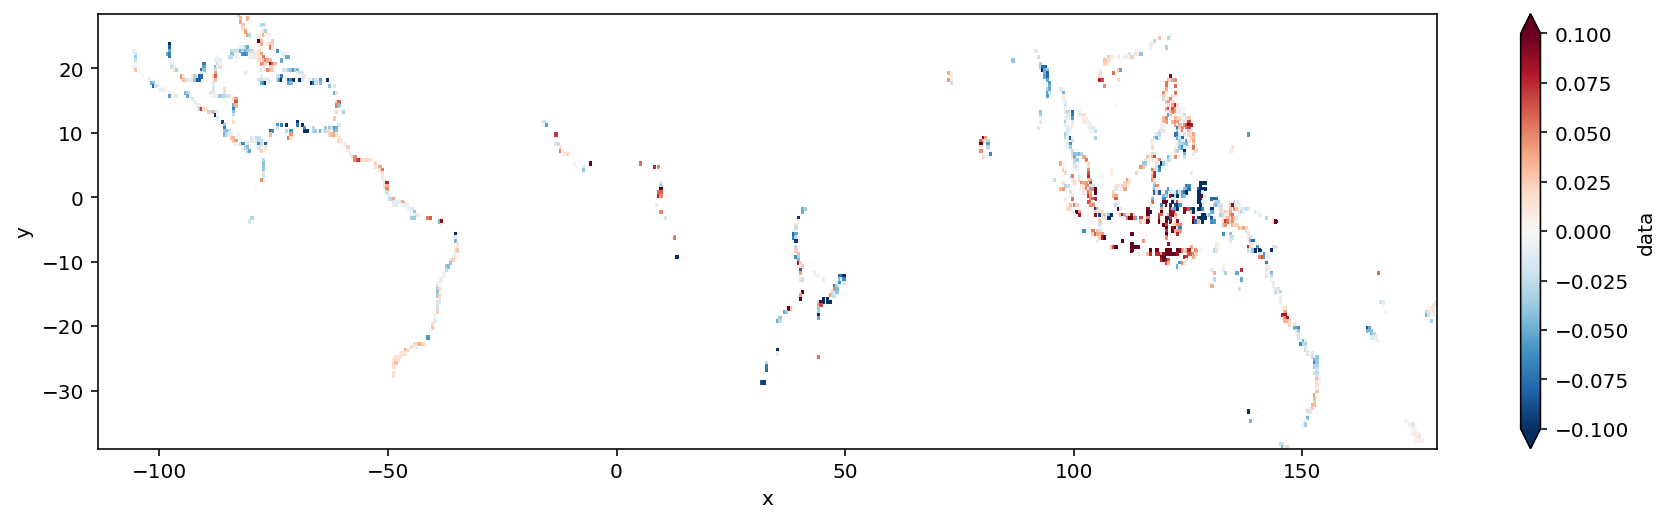

In [13]:
Tsens_EBF.data.plot(figsize=(15,4),vmax=0.1);

## 1.2 Analysis based on ERA5 temperature and CHIRPS precipitation datasets

In [14]:
Tmean = LoadData('/content/drive/MyDrive/Greenness/Climate/Tmean.nc',-10)
pre = LoadData('/content/drive/MyDrive/Greenness/Climate/Pre.nc',0) 

Tsens_EBF,Psens_EBF,r2_EBF,p_Tsens_EBF,p_Psens_EBF,p_EBF = ClimSens(EBF.rename({vi:'data'}),Tmean.rename({'tmp':'data'}),pre.rename({'pre':'data'}))
Tsens_MGF,Psens_MGF,r2_MGF,p_Tsens_MGF,p_Psens_MGF,p_MGF = ClimSens(MGF.rename({vi:'data'}),Tmean.rename({'tmp':'data'}),pre.rename({'pre':'data'}))

filename=['T_EBF_ERA5+CHIRPS.nc','T_MGF_ERA5+CHIRPS.nc','P_EBF_ERA5+CHIRPS.nc','P_MGF_ERA5+CHIRPS.nc']
for i,data in enumerate([Tsens_EBF,Tsens_MGF,Psens_EBF,Psens_MGF]):
  data.to_netcdf('/content/drive/MyDrive/Greenness/Sensitivity/'+filename[i])

filename=['T_pvalue_EBF_ERA5+CHIRPS.nc','T_pvalue_MGF_ERA5+CHIRPS.nc','P_pvalue_EBF_ERA5+CHIRPS.nc','P_pvalue_ERA5+CHIRPS.nc']
for i,data in enumerate([p_Tsens_EBF,p_Tsens_MGF,p_Psens_EBF,p_Psens_MGF]):
  data.to_netcdf('/content/drive/MyDrive/Greenness/Sensitivity/'+filename[i])

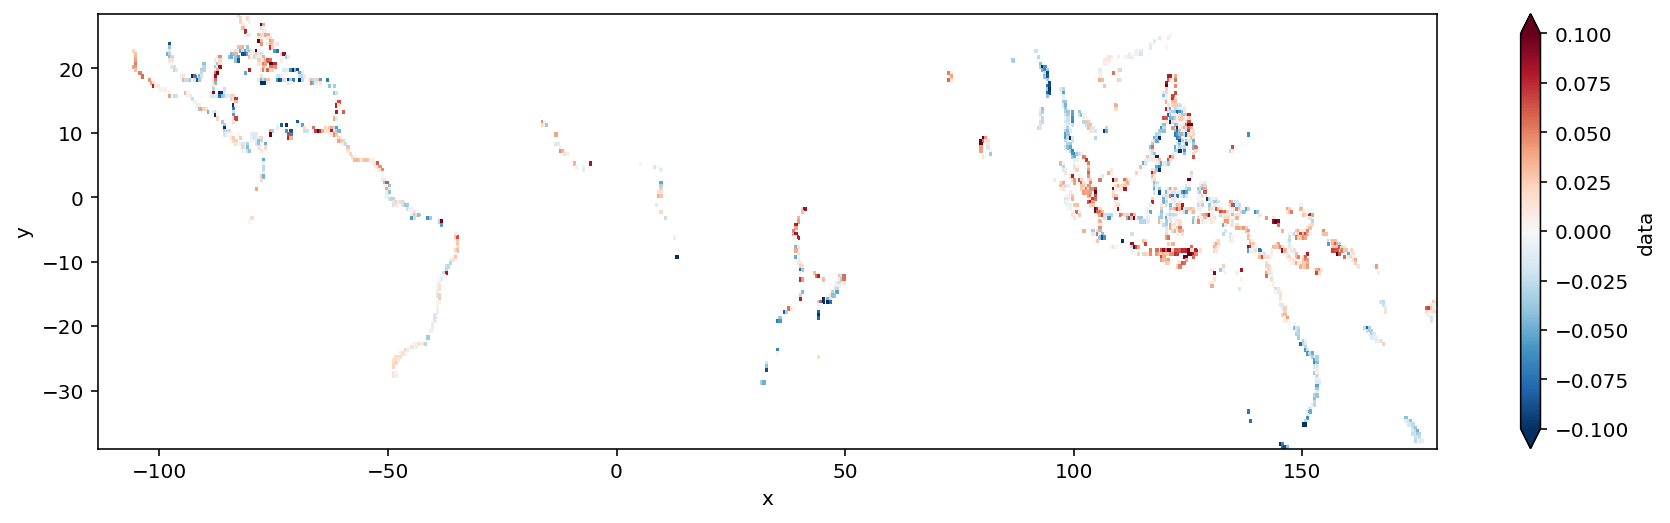

In [15]:
Tsens_EBF.data.plot(figsize=(15,4),vmax=0.1);